In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l2
from tensorflow.keras import layers, models, optimizers
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
from tensorflow.keras.preprocessing import image
import numpy as np
import os

2025-04-23 12:23:02.362944: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745410982.555999      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745410982.615572      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_dir = '/kaggle/input/processed-chest-x-ray-images-pneumonia/chest-xray/resized-CLAHED-train'
test_dir = '/kaggle/input/processed-chest-x-ray-images-pneumonia/chest-xray/resized-CLAHED-test'

# Train verisi için data augmentation içeren generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest',
    validation_split=0.1  # Train verisinden %10 validation ayrılıyor
)
'''veri seti içerisinde yer alan validation klasöründe yeterli görsel olmadığı 
için train veri kümesinden %10 oranında validation verisi ayırımı yapıldı.'''

# Test verisi için sadece rescaling yapan generator
test_datagen = ImageDataGenerator(rescale=1./255)

# Training generator (validation_split'e göre %90 train verisi)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',  # validation_split ile ayrılan veri içinden training kısmı
    shuffle=True
)

# Validation generator (validation_split'e göre %10 validation verisi)
val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

# Test generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 6976 images belonging to 2 classes.
Found 774 images belonging to 2 classes.
Found 780 images belonging to 2 classes.


Normal CNN

In [7]:
input_shape = (224, 224, 3)  # X-ray görüntüleri genelde tek kanallı (grayscale) olur
model = models.Sequential([
layers.Input(shape=input_shape),
layers.Conv2D(32, (3,3), activation='relu'),
layers.MaxPooling2D((2,2)),
layers.Conv2D(64, (3,3), activation='relu'),
layers.MaxPooling2D((2,2)),
layers.Conv2D(128, (3,3), activation='relu'),
layers.MaxPooling2D((2,2)),
layers.Flatten(),
layers.Dense(128, activation='relu'),
layers.Dropout(0.5),
layers.Dense(1, activation='sigmoid')
])

In [8]:
model.compile(
    optimizer=Adam(learning_rate=2e-5),
    loss=BinaryCrossentropy(),
    metrics=['accuracy']
)

# Callbacks: erken durdurma ve öğrenme oranı azaltma
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6,
    verbose=1
)


# Modeli eğitme (fit)
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 87s 363ms/step - accuracy: 0.6674 - loss: 0.5956 - val_accuracy: 0.8798 - val_loss: 0.3324 - learning_rate: 1.0000e-04
Epoch 2/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 85s 378ms/step - accuracy: 0.8938 - loss: 0.2770 - val_accuracy: 0.8953 - val_loss: 0.2711 - learning_rate: 1.0000e-04
Epoch 3/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 80s 354ms/step - accuracy: 0.9085 - loss: 0.2520 - val_accuracy: 0.8437 - val_loss: 0.3385 - learning_rate: 1.0000e-04
Epoch 4/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 80s 358ms/step - accuracy: 0.9139 - loss: 0.2358 - val_accuracy: 0.8695 - val_loss: 0.3112 - learning_rate: 1.0000e-04
Epoch 5/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 81s 360ms/step - accuracy: 0.9219 - loss: 0.2163 - val_accuracy: 0.8850 - val_loss: 0.2667 - learning_rate: 1.0000e-04
Epoch 6/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 83s 370ms/step - accuracy: 0.9221 - loss: 0.2048 - val_accuracy: 0.8979 - val_loss: 0.2648 - learning_rate: 1.0000e-04
Epoch 7/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 94s 42

In [9]:
model.save('cnn_model.h5')

In [10]:
loss, acc = model.evaluate(test_generator)
print(f"Test Accuracy: {acc:.2f}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 570ms/step - accuracy: 0.7423 - loss: 0.6918
Test Accuracy: 0.84


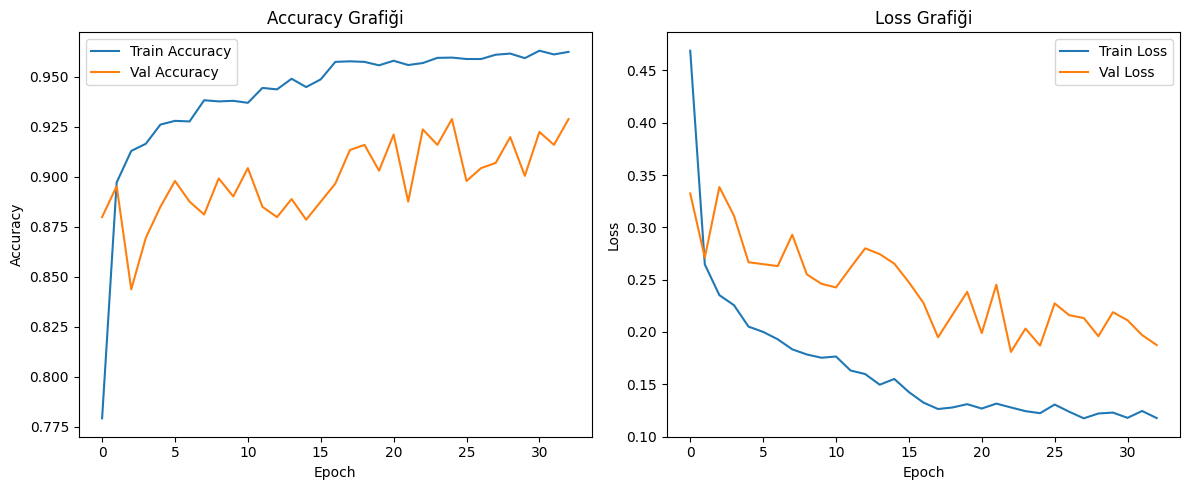

In [11]:
# Şekli ve eksenleri oluştur
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy grafiği
axs[0].plot(history.history['accuracy'], label='Train Accuracy')
axs[0].plot(history.history['val_accuracy'], label='Val Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Accuracy Grafiği')
axs[0].legend()

# Loss grafiği
axs[1].plot(history.history['loss'], label='Train Loss')
axs[1].plot(history.history['val_loss'], label='Val Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Loss Grafiği')
axs[1].legend()

# Grafikleri göster
plt.tight_layout()
plt.show()

In [12]:
# Tahminler (olasılık)
y_pred_probs = model.predict(test_generator)

# Olasılıktan sınıfa (0 veya 1)
y_pred = (y_pred_probs > 0.5).astype("int32").flatten()

# Gerçek etiketler
y_true = test_generator.classes

target_names = list(test_generator.class_indices.keys())

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=target_names))

25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 161ms/step
Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.97      0.72      0.82       390
   PNEUMONIA       0.77      0.97      0.86       390

    accuracy                           0.84       780
   macro avg       0.87      0.84      0.84       780
weighted avg       0.87      0.84      0.84       780



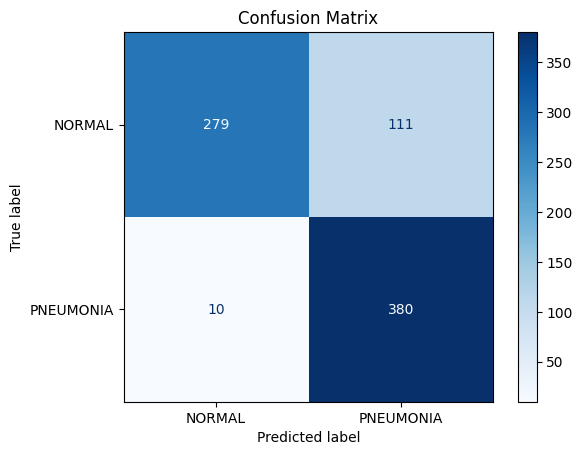

In [13]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

ROC AUC Score: 0.9655


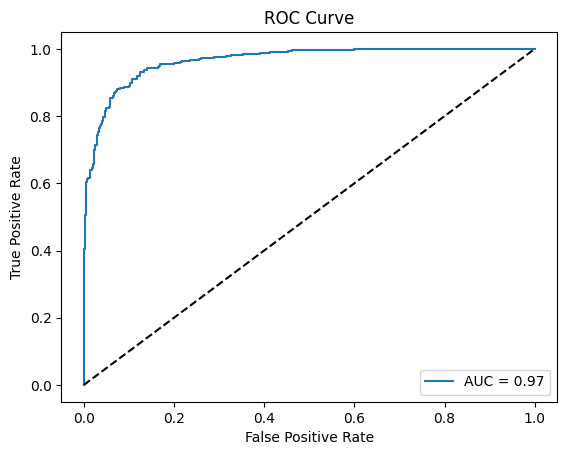

In [14]:
# ROC AUC skoru
auc_score = roc_auc_score(y_true, y_pred_probs)
print(f"ROC AUC Score: {auc_score:.4f}")

# ROC Eğrisi
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)

plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0,1], [0,1], 'k--')  # random guess çizgisi
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

Conv Block ile yapılan cnn

In [29]:
from tensorflow.keras import layers, models

def conv_block(filters):
    return models.Sequential([
        layers.Conv2D(filters, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(filters, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2))
    ])

input_shape = (224, 224, 3)

model_conv = models.Sequential([
    layers.Input(shape=input_shape),

    # Block 1
    conv_block(32),

    # Block 2
    conv_block(64),

    # Block 3
    conv_block(128),

    # Block 4
    conv_block(256),

    # Classification Head
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])


In [30]:
# Modeli derleme
model_conv.compile(
    optimizer=Adam(learning_rate=2e-5),
    loss=BinaryCrossentropy(),
    metrics=['accuracy']
)

# Callbacks: erken durdurma ve öğrenme oranı azaltma
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# Modeli eğitme (fit)
history = model_conv.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 94s 367ms/step - accuracy: 0.8286 - loss: 0.3827 - val_accuracy: 0.5000 - val_loss: 2.8664 - learning_rate: 2.0000e-05
Epoch 2/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 79s 353ms/step - accuracy: 0.9324 - loss: 0.1740 - val_accuracy: 0.5000 - val_loss: 4.1356 - learning_rate: 2.0000e-05
Epoch 3/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 80s 357ms/step - accuracy: 0.9535 - loss: 0.1268 - val_accuracy: 0.6357 - val_loss: 0.8042 - learning_rate: 2.0000e-05
Epoch 4/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 79s 354ms/step - accuracy: 0.9524 - loss: 0.1207 - val_accuracy: 0.8824 - val_loss: 0.2567 - learning_rate: 2.0000e-05
Epoch 5/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 80s 355ms/step - accuracy: 0.9622 - loss: 0.1102 - val_accuracy: 0.9225 - val_loss: 0.1952 - learning_rate: 2.0000e-05
Epoch 6/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 83s 365ms/step - accuracy: 0.9617 - loss: 0.1070 - val_accuracy: 0.8811 - val_loss: 0.2835 - learning_rate: 2.0000e-05
Epoch 7/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 87s 38

In [31]:
model_conv.save('conv_model.h5')

In [32]:
loss, acc = model_conv.evaluate(test_generator)
print(f"Test Accuracy: {acc:.2f}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.8407 - loss: 0.4398
Test Accuracy: 0.90


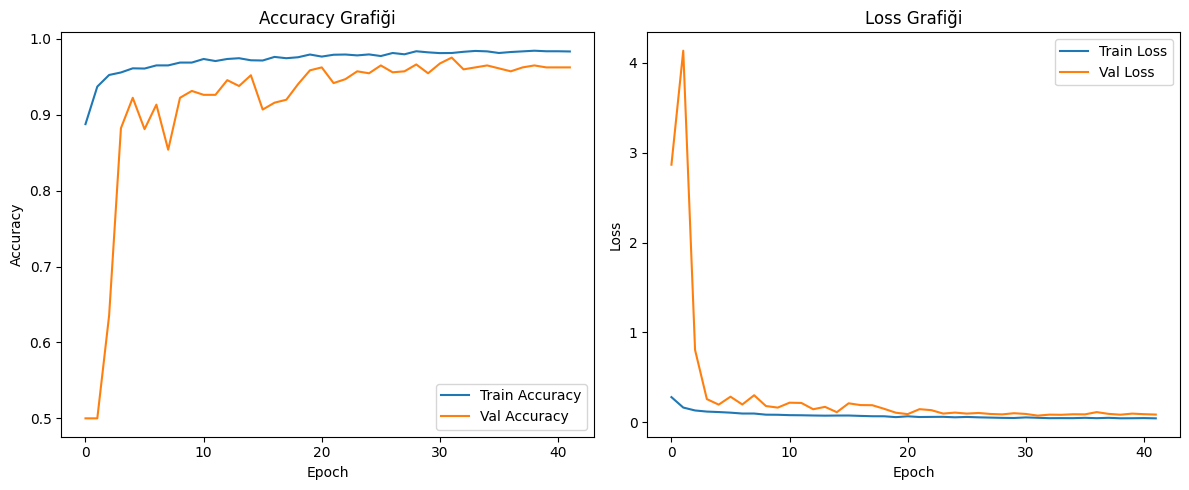

In [33]:
# Şekli ve eksenleri oluştur
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy grafiği
axs[0].plot(history.history['accuracy'], label='Train Accuracy')
axs[0].plot(history.history['val_accuracy'], label='Val Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Accuracy Grafiği')
axs[0].legend()

# Loss grafiği
axs[1].plot(history.history['loss'], label='Train Loss')
axs[1].plot(history.history['val_loss'], label='Val Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Loss Grafiği')
axs[1].legend()

# Grafikleri göster
plt.tight_layout()
plt.show()

In [47]:
# Tahminler (olasılık)
y_pred_probs = model_conv.predict(test_generator)

# Olasılıktan sınıfa (0 veya 1)
y_pred = (y_pred_probs > 0.5).astype("int32").flatten()

# Gerçek etiketler
y_true = test_generator.classes

target_names = list(test_generator.class_indices.keys())

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=target_names))

25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step
Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.98      0.82      0.90       390
   PNEUMONIA       0.85      0.99      0.91       390

    accuracy                           0.90       780
   macro avg       0.92      0.90      0.90       780
weighted avg       0.92      0.90      0.90       780



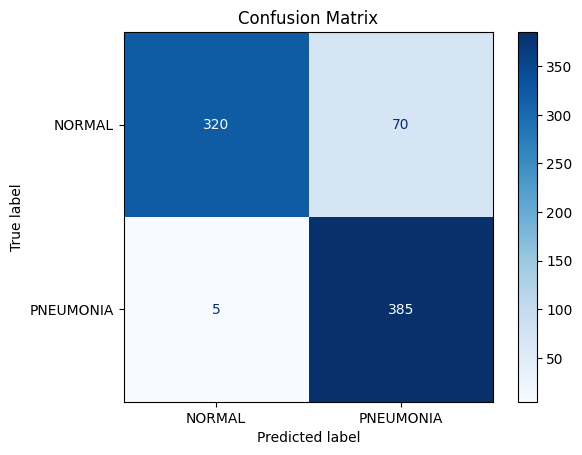

In [48]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

ROC AUC Score: 0.9819


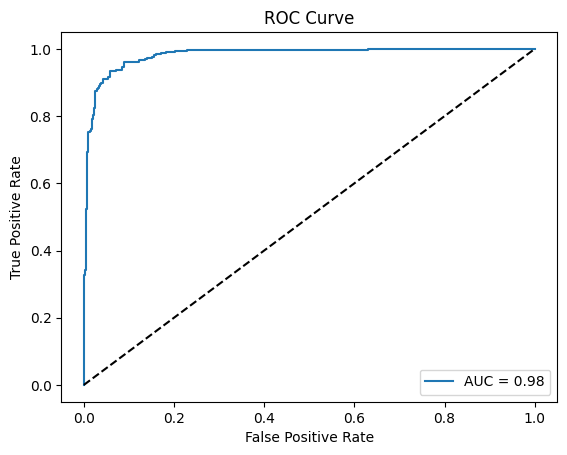

In [49]:
# ROC AUC skoru
auc_score = roc_auc_score(y_true, y_pred_probs)
print(f"ROC AUC Score: {auc_score:.4f}")

# ROC Eğrisi
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)

plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0,1], [0,1], 'k--')  # random guess çizgisi
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

Residual Block ile yapılan cnn

In [37]:
def residual_block(x, filters):
    shortcut = x
    x = layers.Conv2D(filters, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)

    if shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, (1, 1), padding='same')(shortcut)

    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

def build_model(input_shape=(224, 224, 3)):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = residual_block(x, 64)
    x = layers.MaxPooling2D((2, 2))(x)

    x = residual_block(x, 128)
    x = layers.MaxPooling2D((2, 2))(x)

    x = residual_block(x, 256)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs, outputs)
    return model


In [39]:
model_residual = build_model()
model_residual.compile(
    optimizer=Adam(learning_rate=2e-5),
    loss=BinaryCrossentropy(),
    metrics=['accuracy']
)
# Callbacks: erken durdurma ve öğrenme oranı azaltma
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# Modeli eğitme (fit)
history = model_residual.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 95s 369ms/step - accuracy: 0.7231 - loss: 0.5864 - val_accuracy: 0.5000 - val_loss: 2.4267 - learning_rate: 2.0000e-05
Epoch 2/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 80s 355ms/step - accuracy: 0.9106 - loss: 0.2333 - val_accuracy: 0.5000 - val_loss: 2.8607 - learning_rate: 2.0000e-05
Epoch 3/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 82s 367ms/step - accuracy: 0.9377 - loss: 0.1635 - val_accuracy: 0.5000 - val_loss: 2.1840 - learning_rate: 2.0000e-05
Epoch 4/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 84s 375ms/step - accuracy: 0.9514 - loss: 0.1371 - val_accuracy: 0.8928 - val_loss: 0.2298 - learning_rate: 2.0000e-05
Epoch 5/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 83s 369ms/step - accuracy: 0.9586 - loss: 0.1243 - val_accuracy: 0.9315 - val_loss: 0.1871 - learning_rate: 2.0000e-05
Epoch 6/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 82s 364ms/step - accuracy: 0.9572 - loss: 0.1192 - val_accuracy: 0.9432 - val_loss: 0.1559 - learning_rate: 2.0000e-05
Epoch 7/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 82s 36

In [40]:
model_residual.save('residual_model.h5')

In [41]:
loss, acc = model_residual.evaluate(test_generator)
print(f"Test Accuracy: {acc:.2f}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 0.8681 - loss: 0.3672
Test Accuracy: 0.91


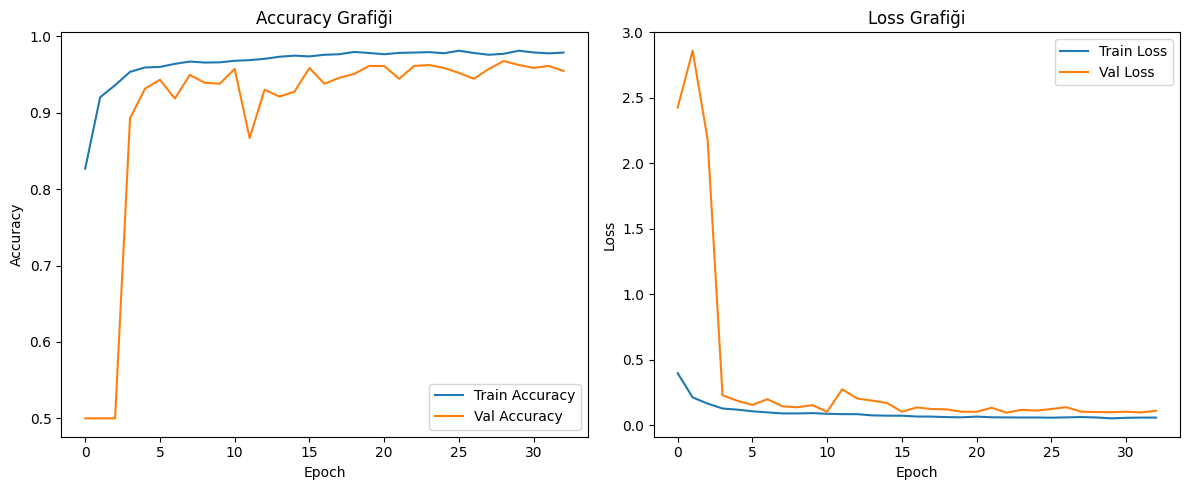

In [42]:
# Şekli ve eksenleri oluştur
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy grafiği
axs[0].plot(history.history['accuracy'], label='Train Accuracy')
axs[0].plot(history.history['val_accuracy'], label='Val Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Accuracy Grafiği')
axs[0].legend()

# Loss grafiği
axs[1].plot(history.history['loss'], label='Train Loss')
axs[1].plot(history.history['val_loss'], label='Val Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Loss Grafiği')
axs[1].legend()

# Grafikleri göster
plt.tight_layout()
plt.show()

In [43]:
# Tahminler (olasılık)
y_pred_probs = model_residual.predict(test_generator)

# Olasılıktan sınıfa (0 veya 1)
y_pred = (y_pred_probs > 0.5).astype("int32").flatten()

# Gerçek etiketler
y_true = test_generator.classes

25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step


In [44]:
target_names = list(test_generator.class_indices.keys())

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=target_names))

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.97      0.84      0.90       390
   PNEUMONIA       0.86      0.98      0.92       390

    accuracy                           0.91       780
   macro avg       0.92      0.91      0.91       780
weighted avg       0.92      0.91      0.91       780



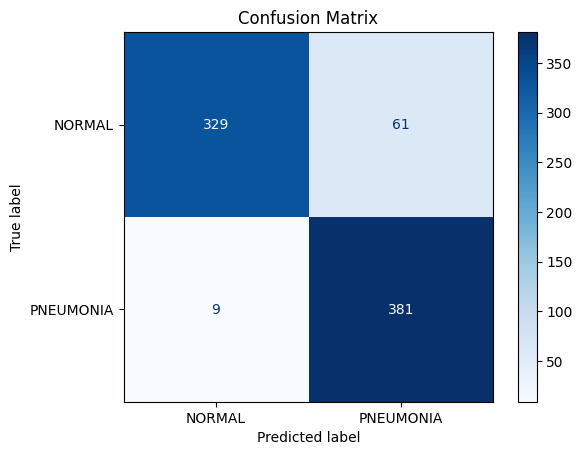

In [45]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

ROC AUC Score: 0.9776


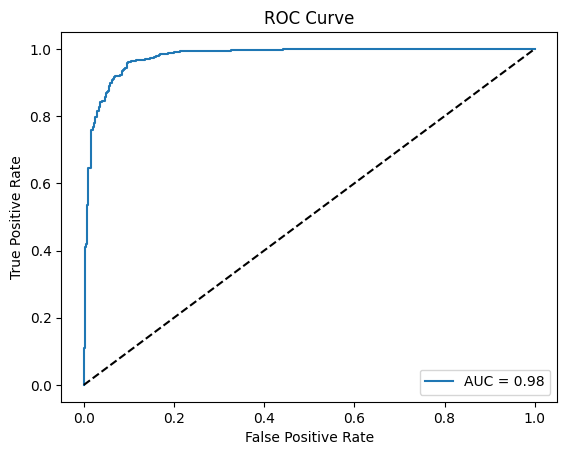

In [46]:
# ROC AUC skoru
auc_score = roc_auc_score(y_true, y_pred_probs)
print(f"ROC AUC Score: {auc_score:.4f}")

# ROC Eğrisi
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)

plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0,1], [0,1], 'k--')  # random guess çizgisi
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

Test veri kümesindeki görseller ile modelin test edilmesi.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 954ms/step


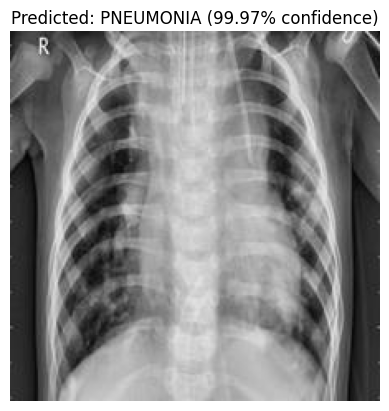

Prediction: PNEUMONIA (Confidence: 99.97%)


In [52]:
test_image_path = '/kaggle/input/processed-chest-x-ray-images-pneumonia/chest-xray/resized-CLAHED-test/PNEUMONIA/person103_bacteria_488.jpeg'

# Görseli yükle ve boyutlandır
img = image.load_img(test_image_path, target_size=IMG_SIZE)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Batch boyutu ekle
img_array /= 255.0  # Normalizasyon (train ile aynı)

# Tahmin yap
prediction = model_residual.predict(img_array)
predicted_class = "PNEUMONIA" if prediction[0][0] > 0.5 else "NORMAL"
confidence = prediction[0][0] if predicted_class == "PNEUMONIA" else 1 - prediction[0][0]

# Görseli ve tahmini göster
plt.imshow(img)
plt.title(f"Predicted: {predicted_class} ({confidence:.2%} confidence)")
plt.axis('off')
plt.show()

print(f"Prediction: {predicted_class} (Confidence: {confidence:.2%})")

Transfer Learning

In [54]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# ResNet152V2 tabanlı model oluşturma
base_model = tf.keras.applications.ResNet152V2(
    weights='imagenet',
    input_shape=(224, 224, 3),
    include_top=False
)
base_model.trainable = False  # Baz modelin ağırlıklarını dondur

def get_pretrained_model():
    inputs = layers.Input(shape=(224, 224, 3))
    
    # ResNet152V2 özellik çıkarıcı
    x = base_model(inputs, training=False)  # training=False çünkü BatchNorm istatistiklerini donduruyoruz
    
    # Özelleştirilmiş "Head" katmanları
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    
    # Çıkış katmanı (binary classification)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs, outputs)
    return model

transfer_learning_model = get_pretrained_model()
transfer_learning_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=2e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Model özetini görüntüle
transfer_learning_model.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet152v2 (Functional)             │ (None, 7, 7, 2048)          │      58,331,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_5           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 58,594,049 (223.52 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 58,331,648 (222.52 MB)

In [55]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = transfer_learning_model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[early_stopping]
)

Epoch 1/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 137s 460ms/step - accuracy: 0.7686 - loss: 0.4906 - val_accuracy: 0.8630 - val_loss: 0.3498
Epoch 2/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 82s 365ms/step - accuracy: 0.9323 - loss: 0.2164 - val_accuracy: 0.8811 - val_loss: 0.2795
Epoch 3/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 82s 366ms/step - accuracy: 0.9401 - loss: 0.1622 - val_accuracy: 0.8928 - val_loss: 0.2542
Epoch 4/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 84s 369ms/step - accuracy: 0.9436 - loss: 0.1487 - val_accuracy: 0.9083 - val_loss: 0.2258
Epoch 5/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 81s 363ms/step - accuracy: 0.9500 - loss: 0.1347 - val_accuracy: 0.9005 - val_loss: 0.2268
Epoch 6/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 83s 370ms/step - accuracy: 0.9551 - loss: 0.1173 - val_accuracy: 0.9121 - val_loss: 0.2103
Epoch 7/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 82s 365ms/step - accuracy: 0.9574 - loss: 0.1103 - val_accuracy: 0.9302 - val_loss: 0.1944
Epoch 8/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 81s 362ms/step - accuracy: 0.9600 - loss: 

In [56]:
transfer_learning_model.save('transfer_lr_model.h5')

In [57]:
loss, acc = transfer_learning_model.evaluate(test_generator)
print(f"Test Accuracy: {acc:.2f}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 291ms/step - accuracy: 0.6933 - loss: 0.7666
Test Accuracy: 0.78


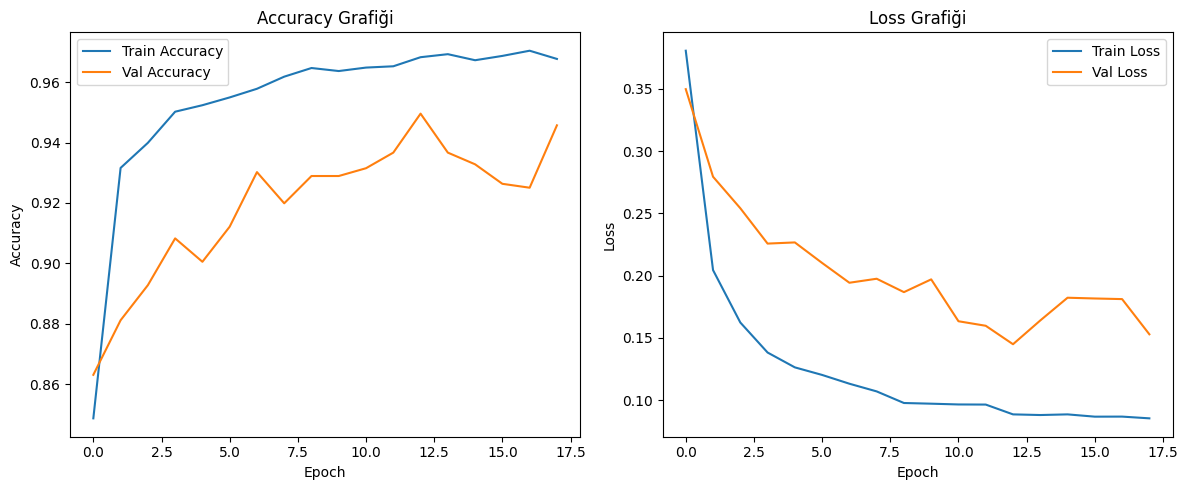

In [58]:
# Şekli ve eksenleri oluştur
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy grafiği
axs[0].plot(history.history['accuracy'], label='Train Accuracy')
axs[0].plot(history.history['val_accuracy'], label='Val Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Accuracy Grafiği')
axs[0].legend()

# Loss grafiği
axs[1].plot(history.history['loss'], label='Train Loss')
axs[1].plot(history.history['val_loss'], label='Val Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Loss Grafiği')
axs[1].legend()

# Grafikleri göster
plt.tight_layout()
plt.show()

In [59]:
# Tahminler (olasılık)
y_pred_probs = transfer_learning_model.predict(test_generator)

# Olasılıktan sınıfa (0 veya 1)
y_pred = (y_pred_probs > 0.5).astype("int32").flatten()

# Gerçek etiketler
y_true = test_generator.classes

25/25 ━━━━━━━━━━━━━━━━━━━━ 24s 527ms/step


In [60]:
target_names = list(test_generator.class_indices.keys())

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=target_names))

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.95      0.59      0.73       390
   PNEUMONIA       0.70      0.97      0.81       390

    accuracy                           0.78       780
   macro avg       0.82      0.78      0.77       780
weighted avg       0.82      0.78      0.77       780



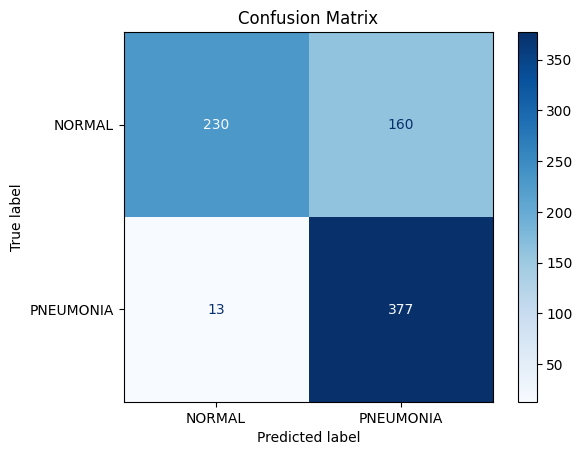

In [61]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

ROC AUC Score: 0.9276


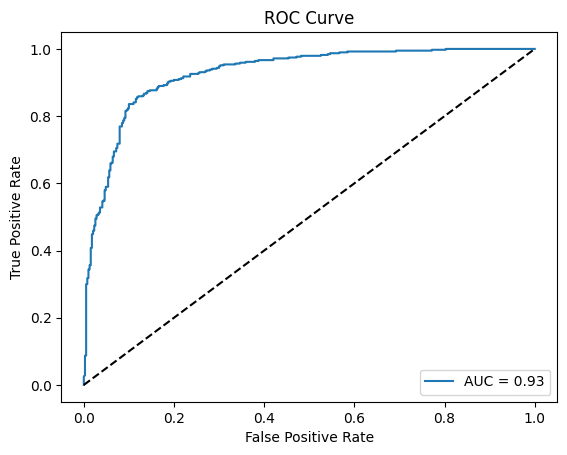

In [62]:
# ROC AUC skoru
auc_score = roc_auc_score(y_true, y_pred_probs)
print(f"ROC AUC Score: {auc_score:.4f}")

# ROC Eğrisi
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)

plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0,1], [0,1], 'k--')  # random guess çizgisi
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

Test veri kümesindeki görseller ile modelin test edilmesi.

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


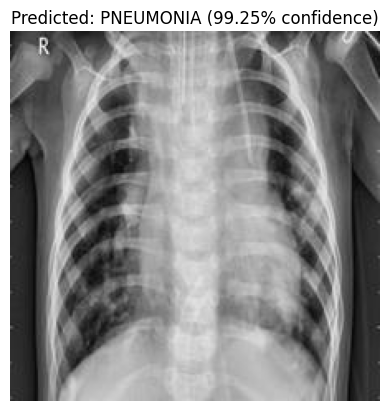

Prediction: PNEUMONIA (Confidence: 99.25%)


In [63]:
test_image_path = '/kaggle/input/processed-chest-x-ray-images-pneumonia/chest-xray/resized-CLAHED-test/PNEUMONIA/person103_bacteria_488.jpeg'

# Görseli yükle ve boyutlandır
img = image.load_img(test_image_path, target_size=IMG_SIZE)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Batch boyutu ekle
img_array /= 255.0  # Normalizasyon (train ile aynı)

# Tahmin yap
prediction = transfer_learning_model.predict(img_array)
predicted_class = "PNEUMONIA" if prediction[0][0] > 0.5 else "NORMAL"
confidence = prediction[0][0] if predicted_class == "PNEUMONIA" else 1 - prediction[0][0]

# Görseli ve tahmini göster
plt.imshow(img)
plt.title(f"Predicted: {predicted_class} ({confidence:.2%} confidence)")
plt.axis('off')
plt.show()

print(f"Prediction: {predicted_class} (Confidence: {confidence:.2%})")